# 

# Notiezen und Information zu dem Entwiklungsstatus

Dies sind die Notizen zum aktuellen Stand der Umsetzung von IIR-Biquad-Filtern auf dem PYNQ-Z2. <br> Die Jupyter-Notebooks befinden sich im Verzeichnis *jupyter*. <br> **Wichtig**: Es kann sein, dass die Notebooks nicht vollständig in git angezeigt werden! Beim Öffnen mit einem externen Programm (z.B. VSCode) wird das gesammte Notebook angezeigt.

# Stand : 09.06.2025

### Filter:

Der derzeit implementierte Filter dient als funktionsfähiger Platzhalter. Es handelt sich um ein Butterworth-Hochpassfilter mit einer Grenzfrequenz von 1 kHz und einer Abtastrate von 48 kHz, abgestimmt auf den im PYNQ-Z2 integrierten Audiocodec [ADAU1761](https://www.analog.com/en/products/adau1761.html). <br> Der Filter wurde mithilfe des HDL-Coders aus einem MATLAB/Simulink-Modell generiert und als IP-Core umgesetzt, um eine nahtlose Integration in Vivado zu ermöglichen. <br>

### JupiterNotebooks:

#### Filter_TransmissionTest/Matlab_Filter_Test_TransmissionTest_v2\|v5

Diese beiden Notebooks dokumentieren die ersten erfolgreichen Versuche, zunächst simulierte Signale und anschließend beide Kanäle einer .wav-Datei zu filtern. Die Signale wurden dabei als np.array per DMA (Direct Memory Access) an den Filter übertragen, verarbeitet und anschließend wieder ausgegeben. <br> Vor der Übertragung werden die Arrays in Pakete von jeweils 262144 Elementen aufgeteilt. Diese Paketgröße entspricht der Größe des Output-Buffers der Filter-IP. Durch die automatische Paketaufteilung lassen sich auch Daten beliebiger Länge problemlos übertragen. <br> Der Ein- und Ausgangsbuffer des DMA wurde vorsorglich auf den Maximalwert von 67108864 gesetzt.

Beim Erstellen der DMA-Buffer in Python werden diese mit undefinierten Werten befüllt, die intern als NaN (Not a Number) oder nicht-initialisierte Daten erscheinen können. Beim Anzeigen per print() wirken sie zwar wie Nullen, enthalten aber tatsächlich keine gültigen, interpretierten Werte.<br> Wenn der Buffer größer ist als die tatsächlich zu übertragenden Daten und nicht vollständig mit gültigen Werten überschrieben wird, bleiben diese ungültigen Inhalte im Speicher. Werden diese vom DMA übertragen, kann dies zu internen Fehlerzuständen führen, wodurch der DMA blockiert wird und weitere Übertragungen nicht mehr möglich sind.<br> Um dennoch mit großen DMA-Frames arbeiten zu können, müssen die Buffer vollständig mit gültigen Daten gefüllt werden.<br>

**Lösung:** Vor der Übertragung wird der gesamte Buffer initial mit Nullen befüllt (Padding). Anschließend werden die tatsächlichen Nutzdaten am Anfang des Buffers überschrieben. Dadurch enthält der komplette Buffer gültige, wohldefinierte Werte, was dem DMA eine fehlerfreie Übertragung ermöglicht.

#### Audio_Filter_Test_v2/Codec_Test_v6

Dieses Notebook ist eine erweiterung der Vorherigen. Das hier verwendete Design basiert vollständig auf dem des *base.bit* welches vom [Pynq Github Repo](https://github.com/Xilinx/PYNQ/tree/master) stammt und auch in den Beispielen aus der [Docs » PYNQ Libraries » Audio](https://pynq.readthedocs.io/en/v2.6.1/pynq_libraries/audio.html) angewand wird. Dabei wurde praktisch nur der für den [ADAU1761 Audio-Codec](https://www.analog.com/en/products/adau1761.html) erstellte Teil des Designs übernommen.

<figure>
<embed src="attachment:Design/audio_test_ref_design.pdf" />
<figcaption aria-hidden="true">Blockdiagramm_Referenz</figcaption>
</figure>

Hinzugefügt wurde der im Vorheriegen Notebook erstellte Filter und DMA, um vom Board aufgenommende Audio direkt Filtern zu können.

<figure>
<embed src="attachment:Design/audio_test_3_ref.pdf" />
<figcaption aria-hidden="true">Blockdiagramm_Referenz</figcaption>
</figure>

Die angewanden Funktionen stammen aus dem [pynq.lib.audio Module](https://pynq.readthedocs.io/en/v2.6.1/pynq_package/pynq.lib/pynq.lib.audio.html#pynq-lib-audio).

### Bekannte Probleme:

-   Die Auswahl des Audio-Eingangs ist nicht immer zuverlässig und muss teilweise mehrfach durchgeführt werden.
-   Der Python-Kernel stürzt bei größeren Datensätzen regelmäßig ab, wodurch die Verbindung zum Board verloren geht. → Die Abstürze treten scheinbar zufällig auf und folgen keinem erkennbaren Muster. Ein Hardreset ist anschließend erforderlich.
-   Beim Laden eines neuen Overlays wird dieses nicht immer korrekt übernommen: das vorherige Overlay wird manchmal nicht überschrieben. → Auch hier ist ein Hardreset notwendig.
-   Aufnahmen bei höherer Lautstärke können Störgeräusche oder Rückkopplungen verursachen.
-   Aufgenommene Audiodateien sind im Vergleich zur Ausgabe über das Board deutlich leiser.
-   Ausgabe rauscht, potenzielle Folge vom Filtertyp oder der Umrechnung vor dem Filtern

## Echtzeitfiltrierung

### Probleme mit Echtzeit

#### Ausgangslage

Um das I2S Signal Echtzeitfiltern zu können, muss der Filter zwischen dieses Signal gesetzt werden. In Vivado gibt es I2S Receiver/Transmitter Ip-Cores welche ein I2S Signal annehmen können und als AXI4-Stream ausgeben können und andersrum mit dem Transmitter. Der Filter kann als AXI4-Stream fähiger IP-Core in Matlab erstellt werden und wurde so auch bisher verwendet. Daher könnte der Filter über die I2S Receiver/Transmitter Blöcke an den I2S-Stream angebunden werden.

#### Problem mit I2S Receiver/Transmitter

Der Audio_Codec_Contrtoller Block ist ein vorgefertigter IP-Core aus dem [Pynq Github Repo](https://github.com/Xilinx/PYNQ/tree/master) welcher bei der I2S Übertragung als Master funktioniert und damit *bclk*, *lrclk* und *codec_addr* vorgibt.<br> Das Problem mit den I2S Receiver/Transmitter Ip-Cores ist, dass diese in dieser Konfiguration als *Slave* arbeiten müssten. Die Funktion wird aber nicht unterstützt. Bedeutet das die IP-Cores nur als *Master* Arbeiten können. [I2S Transmitter and I2S Receiver LogiCORE IP Product Guide](https://docs.amd.com/r/en-US/pg308-i2s/Navigating-Content-by-Design-Process) <br> Also muss entweder eine andere IP mit Unterstützung als *Slave* her oder dies muss eigens entwickelt werden. <br> Alternativ könnte auch der Filter IP-Core so umgestaltet werden, dass dieser ein Eingangs I2S-Streams akzeptiert. Dadurch würde sie aber die voraussichtlich die Unterstützung von AXI4-Stream verlieren, wodurch diese auch nicht länger für Digitale Audioquellen wie *.wav* verwendet werden könnten, weshalb derselbe Filter zweimal erstellt werden mussen. <br> Es gibt eine Möglichkeit die I2S Receiver/Transmitter von *Master* in *Slave* umzuändern laut dieser Quelle: [Audio Processing with the Snickerdoodle](https://www.hackster.io/adam-taylor/audio-processing-with-the-snickerdoodle-727c40). Anderes Board aber änhliche SoC. Leider gelang es mir bisher nicht diese erfolgreich anzuwenden.

##### Takt-Daten-Desynchronisation bei Slave-Slave-Betrieb

Wenn Receiver und Transmitter beide Slave sind, verwenden sie bclk und lrclk vom codec_ctrl_0 <br> **Das Problem ist:** Der i2s_receiver_0 wandelt das serielle Signal sdata_i in AXI-Wörter (z.B. 24 Bit). Diese passieren eine Verarbeitung, z.B. dein Filter. Danach gibt i2s_transmitter_0 sie zurück, synchron zu **alten** Taktsignalen (bclk, lrclk) <br> - Die Daten sind nun potenziell verzögert, und stimmen nicht mehr zur aktuellen lrclk/bclk-Phase.<br>

##### Master-Transmitter bricht den Systemtakt

Wenn ich den Transmitter als Master einstelle, erzeugt er eigene bclk und lrclk. Damit erzeugt er ein I²S-Signal mit eigenem Timing, und der audio_codec_ctrl_0 (und damit der Codec) müssten nun als Slave arbeiten. <br> - *Der Controller ist als Takt-Master hart konfiguriert*, also: **Kann bclk/lrclk nicht extern empfangen, sondern erzeugt sie.**

##### Gleichzeitige Audio-Wiedergabe und -Ausgabe

In dem [Pynq-Z2](https://www.mouser.com/pdfDocs/pynqz2_user_manual_v1_0.pdf) ist ein [ADAU1761 Audio-Codec](https://www.analog.com/en/products/adau1761.html) verbaut. In dem Datenblatt wird nicht expleziet erwähnt ob eine gelcihzeitige Aufnahme und Wiedergabe möglich ist, technisch währe es aber. Wenn die Funktionen aus dem [pynq.lib.audio Module](https://pynq.readthedocs.io/en/v2.6.1/pynq_package/pynq.lib/pynq.lib.audio.html#pynq-lib-audio) verwendet werden wird, ist es nicht möglich. Sobald eine Aufnahme *.record(Time)* gestart wird, wird die Ausgabe *.play()* blockiert bis die Aufnahme vollendet ist. <br> Mit dem Base-Design, sowie auch diesem hier, ist so direckt die gleichzeitige aufnahme und wiedergabe nicht möglich.

#### Alternative Design Möglichkeiten

Es gibt andere Projekte welche es ermöglichen gelichzeitig Audio Aufzunehmen und Widerzugeben. Inwieweit diese hier verwendet werden können muss noch weiter unteruscht werden. <br> Hier eine Liste von Projekten die bereits ausprobiert wurden: <br>

[Pynq_Z2-Audio](https://github.com/wady101/PYNQ_Z2-Audio/tree/master) <br> [Audio Processing with the Snickerdoodle](https://www.hackster.io/adam-taylor/audio-processing-with-the-snickerdoodle-727c40)<br> [pynq-audio](https://github.com/reed-foster/pynq-audio/tree/master)<br> [Pynq-Z2-Audio-Video-Pipelines](https://github.com/tmaringer/Pynq-Z2-Audio-Video-Pipelines) <br>

# Stand : 11.06.2025

### Filter:

Zwei neue Filter wurden entworfen und jeweils in Kombination mit einer eigenen AXI-DMA implementiert. Die Filterdesigns basieren auf dem MATLAB Filter Designer, wobei die entsprechenden Koeffizienten ins Workspace exportiert wurden: - Hochpass: Butterworth, 4. Ordnung, FC: 2500 Hz - Tiefpass: Butterworth, 4. Ordnung, FC: 1000 Hz

Das Simulink-Modell *(biquad_Filter_v7_IP)* wurde entsprechend angepasst: Die Gain-Faktoren *(g)* werden nun direkt in die Numerator-Koeffizienten integriert. Da der MATLAB Filter Designer für jeden Biquad-Block einen eigenen Gain-Wert erzeugt, liegen nun entsprechend mehr Gain-Faktoren vor.

Diese Änderung wurde vorgenommen, da beim Tiefpassfilter die nachträgliche Anwendung des Gains dazu führte, dass die Werte zu klein wurden. Aufgrund des 32_16 Fixed-Point-Formats im Simulink-Modell kam es dadurch zu Rundungsfehlern bzw. zum Wegfallen relevanter Werte. Durch das Vorab-Einrechnen der Gains in die Numerator-Koeffizienten wird dieses Problem vermieden, ohne dass sich das Filterverhalten ändert.

### Vivado Design:

Im Zuge der neuen Filter wurde auch das Design in Vivado angepasst. Als Grundlage diente das überarbeitete Referenzdesign v2, das eine angepasste Takterzeugung für den Audio-Codec beinhaltet. Jeder der beiden Filter erhält eine eigene AXI-DMA-Schnittstelle, wobei beide Schnittstellen identisch konfiguriert wurden. <br>

<figure>
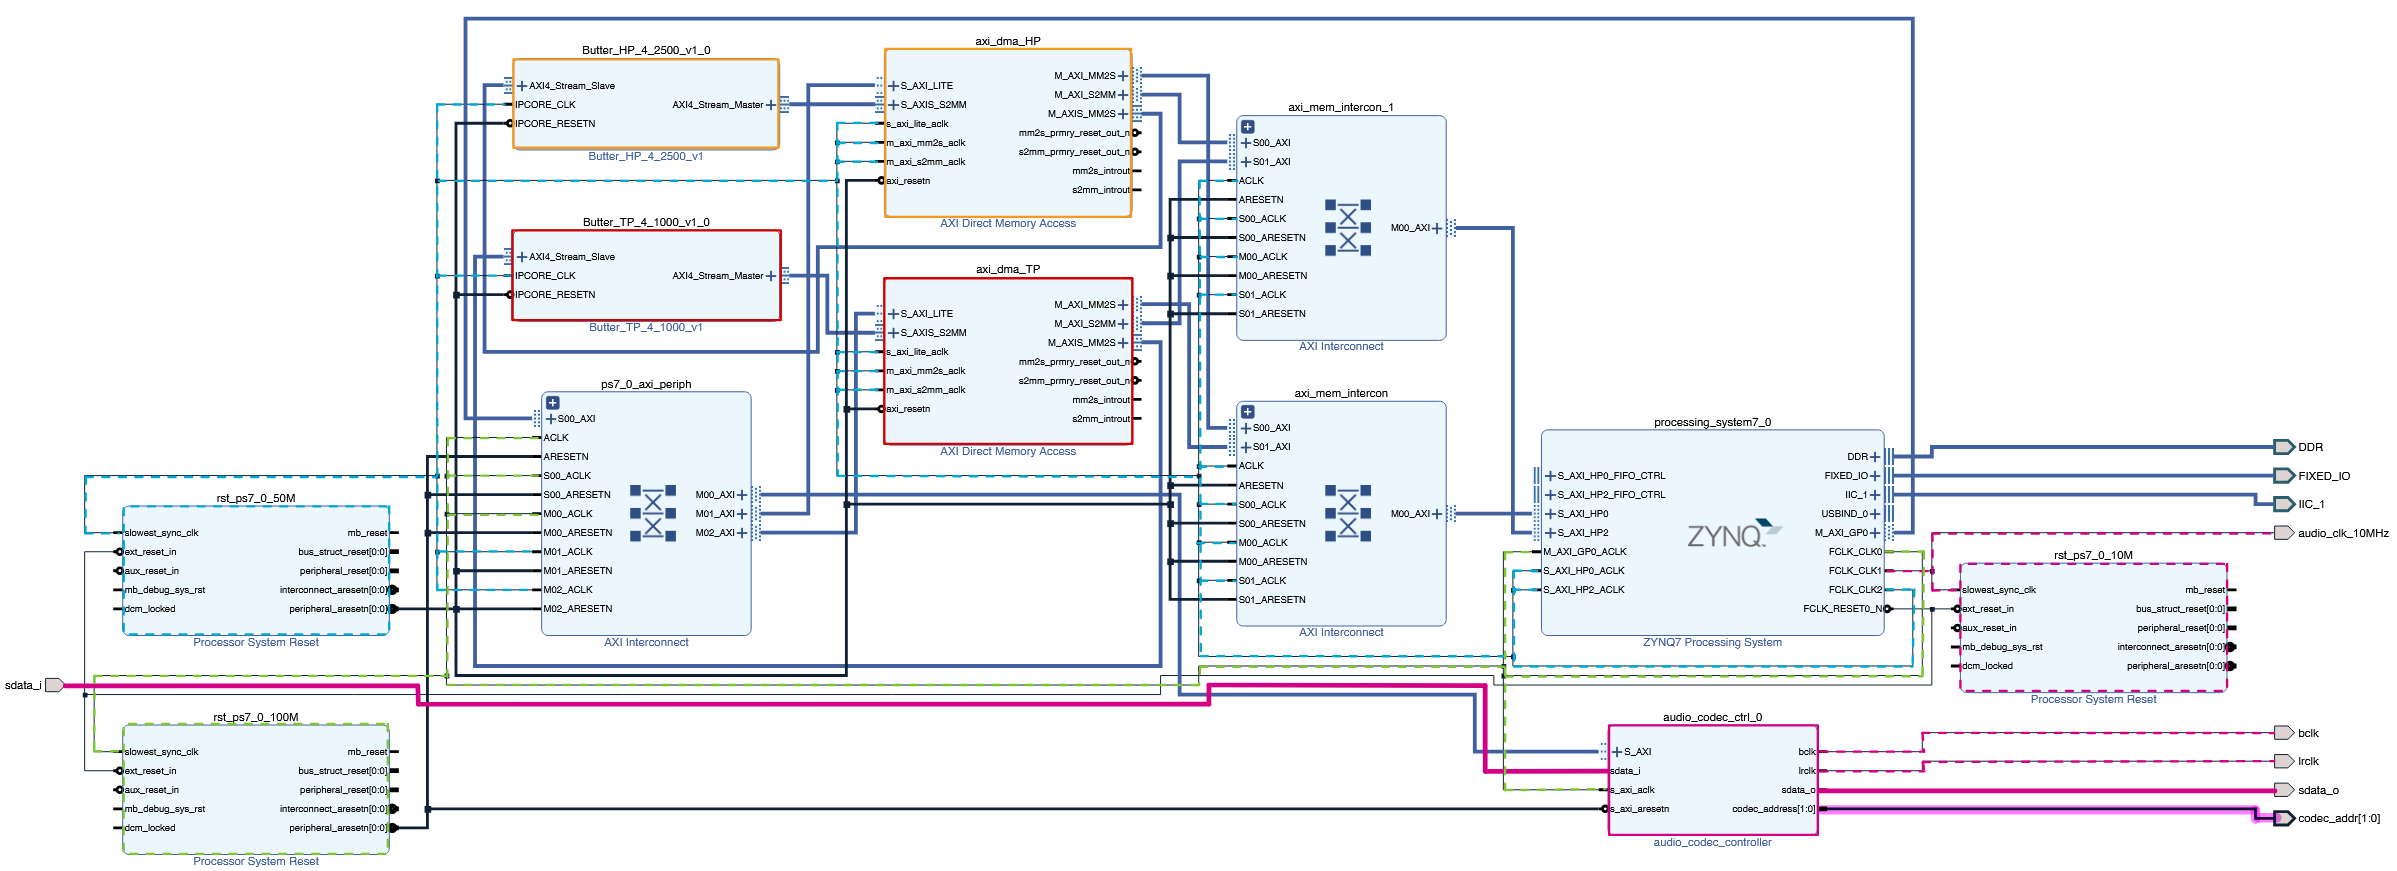
<figcaption aria-hidden="true">audio_duo_Filter_v1</figcaption>
</figure>

Beim ersten Versuch der Bitstream-Generierung trat ein Synthese-Fehler auf. Nach erneutem Ausführen des Generierungsprozesses konnte der Bitstream jedoch erfolgreich erstellt werden. Ein solches Verhalten wurde bereits in der Vergangenheit bei größeren Designs beobachtet und hatte bislang keine Auswirkungen auf die Funktionalität des erzeugten Bitstreams. <br>

Die Timings im Design wurden erfolgreiuch eingehalten. 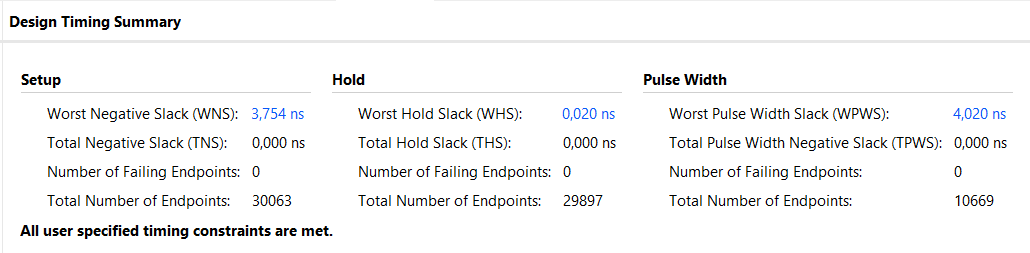

### JupiterNotebooks:

#### Audio_duo_Filter_v1

Das Notebook basiert auf einer früheren Version und unterscheidet sich hauptsächlich in der Anzahl der implementierten Filter. Es wurde dahingehend erweitert, dass einer der beiden Filter zur Laufzeit ausgewählt werden kann. Das Notebook diente zur Überprüfung der Funktionalität des Designs – der Test verlief erfolgreich, die korrekte Funktion konnte bestätigt werden.

# Stand : 12.06.2025

### JupiterNotebooks:

#### Audio_duo_Filter_v2

Aktualisierte Version von *Audio_duo_Filter_v1*. <br> Erweitert wurde das Projekt um eine Dokumentation der verwendeten Funktionen, sowohl der Pynq-eigenen als auch der selbst entwickelten. <br> Zudem wurde die Filterverarbeitung von 16-Bit auf vollständige 24-Bit erweitert. <br> Zur Überprüfung wurden die Phasenantworten des Hochpass- (HP) und Tiefpassfilters (TP) analysiert.

#### Audio_duo_Filter_v3

Die Funktionen wurden in eine separate Python-Datei (*my_Overlay.py*) ausgelagert, um die Übersichtlichkeit des Notebooks zu verbessern. Zusätzlich wurde eine neue Funktion integriert, die den gesamten Filterprozess, einschließlich Übertragung, Einlesen, Speichern sowie Filterauswahl, in einem einzigen Aufruf zusammenfasst. <br> Alle bisherigen Funktionen bleiben unverändert und funktionieren weiterhin wie zuvor.

### Bemerkungen:

-   Die Audioaufnahme über das Board ist nicht immer fehlerfrei.
-   In seltenen Fällen tritt bei der Filterung ein Problem auf, bei dem starke Frequenzspitzen im Bereich von 10–20 kHz entstehen. Die Ursache dafür ist bislang unbekannt: beobachtet wurde dieses Verhalten bisher nur einmal beim Tiefpassfilter.
-   Die Filterwirkung des Hochpassfilters bei einer Grenzfrequenz von 2500 Hz ist unbefriedigend, es werden zu viele Frequenzanteile abgeschnitten, was zu einem unsauberen Klang führen kann.
-   Beim Einsatz von Python-Bibliotheken wie matplotlib kommt es bei längeren Aufnahmen zu Instabilitäten im Python-Kernel. Eine Auslagerung der Auswertungen in ein separates Notebook ist daher geplant.

# Stand : 13.06.2025

### JupiterNotebooks:

#### Lerndemo_v1_Audio

Neues Notebook sowie eine aktualisierte Version von *my_Overlay_v2.py* mit erweiterten Funktionen für grafische Darstellung der Ergebnisse. - Enthält eine Funktion zur Darstellung eines einfachen Frequenzspektrums beider Audiokanäle auf Basis einer FFT. - Zusätzlich wurde eine Funktion integriert, die die Audiodaten im Zeitbereich visualisiert.

### Bemerkungen:

-   Die maximale Aufnahmezeit beträgt 60 Sekunden und ist durch den Audio-Codec-Treiber begrenzt.
-   Die Ursache für Instabilitäten liegt vermutlich in einer Speicherüberlastung, bedingt durch die maximale Aufnahmezeit in Kombination mit zahlreichen geladenen Bibliotheken und Plot-Ausgaben, die gemeinsam den RAM überfüllen.
-   Eine empfohlene Aufnahmezeit von 30 Sekunden hat die Stabilität deutlich verbessert und auch die allgemeine Verarbeitungszeit des Notebooks reduziert.

## Noch offene Punkte:

-   ❌ Finales Design mit Audiofilterung und Einlesen digitaler Audiodateien (.wav)
-   ❌ Dokumentation zu: DSP, IIR-Filter, Biquad-Strukturen, Matlab HDL-Coder + Simulink, Vivado, IP-Cores, AXI, I2S, (I2C), Pynq und Pynq-Z2 Board
-   ❌ Umrechnung der Samplerate für externe *.wav*-Datein (44.1 -\> 48kHz)

## Bereits erledigt:

-   ✅/❌ Design eines digitalen IIR-Biquad-Filters mit Fixpunktkonvertierung der Koeffi- zienten für den FPGA.
-   ✅ Erstellung und Einbindung des Filters als AXI-fähiger IP-Block in Vivado 2022.1
-   ✅ Erstes Design mit Zynq-Processing-System und DMA-Block (Direct Memory Access) für das erste Filtern simulierter Werte.
-   ✅✅/❌ **JupiterNotebooks für Demonstration**
-   ✅✅/❌ Skript zur Steuerung des Filters auf PYNQ.
-   ✅✅/❌❌ Realesierung der 4 Basisfilter (*HP, TP, BS, BP*)
-   ✅ **Erstes Design einer Lerndemonstration mit Visualisierung der Signalverarbeitung.**

## Zusatz:

-   ❔Vergleich Filtertypen und Ordnung (Ellip, Butter, Chebyshev)
-   ❔Design für die **Echtzeit-Audiofilterung** mit Audiocodec über I2S